In [1]:
using LowRankModels
using PyPlot
using CSV
using ProgressMeter
using Statistics
using StatsBase
using LaTeXStrings
using Printf
using JLD2

# Load Henry coefficient matrix `H`

see `CreateMatrix.ipynb` for Python code that queries the NIST database for the adsorption data and fits Henry's law to the adsorption data to identify the Henry constant.

the gases run along the columns, the materials run along the rows, and the entries are the Henry coefficients identified from experimental adsorption data.

In [2]:
@load joinpath("data", "logH_matrix_materials_and_gases.jld2") H master_list_of_materials master_list_of_gases MSE
#H = deepcopy(new_H) # log(H)
materials = String.(deepcopy(master_list_of_materials)) # list of materials, order corresponding to rows in H
gases = String.(deepcopy(master_list_of_gases)) # list of gases, order corresponding to cols in H

nm, ng = size(H) #no. of materials and gases

@assert length(materials) == nm && length(gases) == ng

In [3]:
sum(ismissing.(H))/length(H)

0.9044608901223147

In [4]:
@printf("Maximum value in H is: %.3f\n", maximum(skipmissing(H)))
@printf("Minimum value in H is: %.3f\n", minimum(skipmissing(H)))

Maximum value in H is: 7.706
Minimum value in H is: -6.618


## sort rows, cols according to the number of observations
... and sort `materials` and `gases` accordingly!

In [5]:
function sort_rows_cols_acc_to_nb_obs!(H::Array{Union{Float64, Missing}, 2},
                                       MSE::Array{Union{Float64, Missing}, 2},
                                       materials::Array{String, 1}, 
                                       gases::Array{String, 1})
    # rows
    nb_obs = [sum(.! ismissing.(H[i, :])) for i = 1:nm]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[ids_reorder, :]
    MSE .= MSE[ids_reorder, :]
    materials .= materials[ids_reorder]

    # cols
    nb_obs = [sum(.! ismissing.(H[:, j])) for j = 1:ng]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[:, ids_reorder]
    MSE .= MSE[:, ids_reorder]
    gases .= gases[ids_reorder]

    # sanity check
    @assert sum(ismissing.(H[:, 1])) <= sum(ismissing.(H[:, 3])) # first row has fewer missing values
    @assert sum(ismissing.(H[1, :])) <= sum(ismissing.(H[3, :])) # first col has fewer missing values
    return nothing
end

sort_rows_cols_acc_to_nb_obs!(H, MSE, materials, gases)

## prune matrix by selecting rows/cols with the most observations

In [6]:
nm, ng = size(H)
nm = 50
ng = 25

H = H[1:nm, 1:ng]
MSE = MSE[1:nm, 1:ng]
materials = materials[1:nm]
gases = gases[1:ng];

sort_rows_cols_acc_to_nb_obs!(H, MSE, materials, gases)
println("min # observations in a row: ", sum(.! ismissing.(H[end, :])))
println("min # observations in a col: ", sum(.! ismissing.(H[:, end])))
# TODO copy Arni's code for viz of frequency of observations gases and mofs

min # observations in a row: 4
min # observations in a col: 4


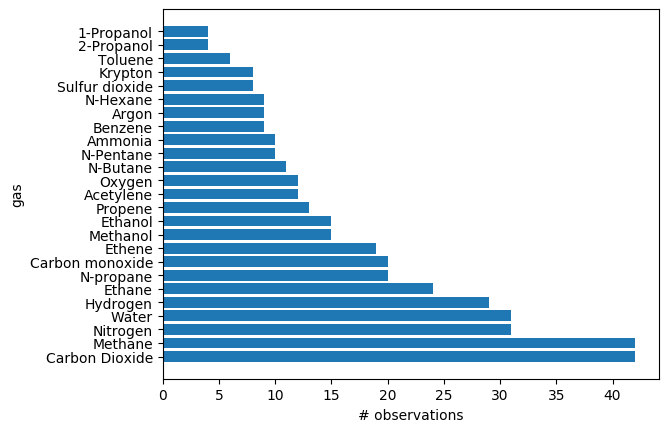

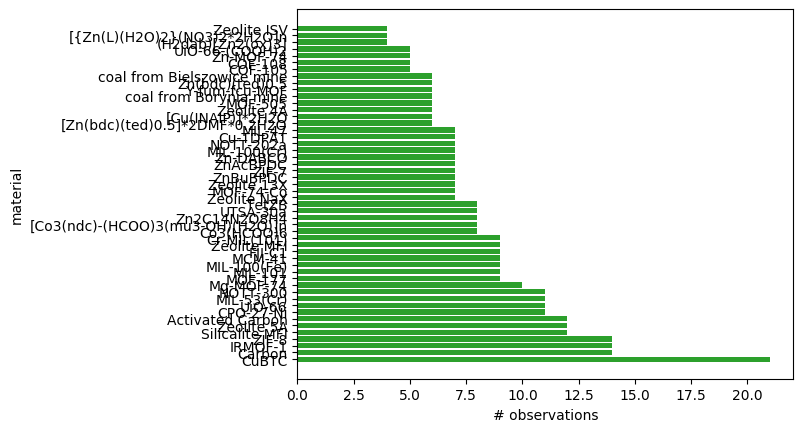

PyObject Text(24.000000000000043, 0.5, 'material')

In [7]:
plt.figure()
barh(gases, [sum(.! ismissing.(H[:, j])) for j = 1:ng])
xlabel("# observations")
ylabel("gas")

plt.figure()
barh(materials, [sum(.! ismissing.(H[i, :])) for i = 1:nm], color="C2")
xlabel("# observations")
ylabel("material")

## visualize

here, a diverging colormap is appropriate since the columns are standardized.

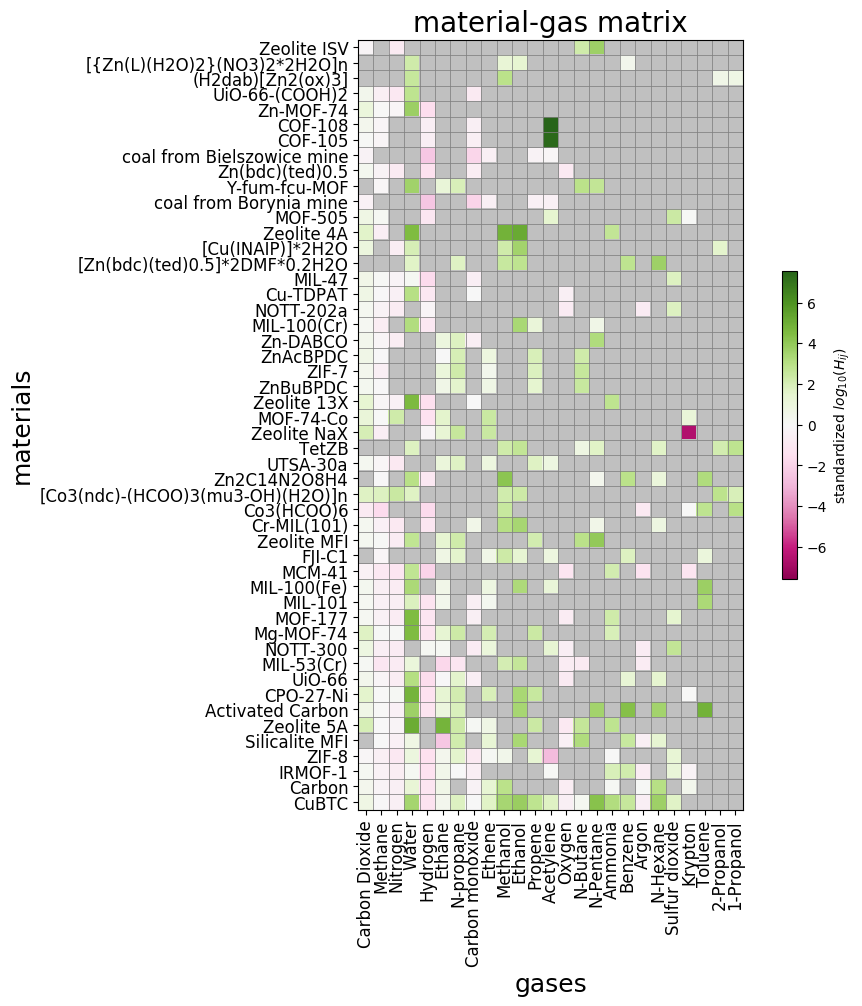

In [8]:
spy_H = deepcopy(H)
spy_H[ismissing.(H)] .= 0.0

spy_H2 = fill(0.0, size(H))
spy_H2[.!ismissing.(H)] .= 0
spy_H2[ismissing.(H)] .= 1

fig, ax = subplots(figsize=(10, 10))
img = ax.pcolormesh(spy_H, cmap="PiYG", 
    vmax=maximum(abs.(spy_H)), vmin=-maximum(abs.(spy_H)))
cbar = colorbar(img, label=L"standardized $log_{10}(H_{ij})$", shrink=0.4)

#cmap = plt.get_cmap("PiYG")
#colors = cmap(collect(1:cmap.N))
colors = Array{Float64, 2}(undef, 2, 4)
colors[1, :] .= [255.0, 255.0, 255.0, 0.0] ./ 255
colors[2, :] .= [192., 192., 192., 255.] ./ 255
cmap = matplotlib.colors.ListedColormap(colors)
img = ax.pcolormesh(spy_H2, cmap=cmap)

# grid lines
for x = 1:nm
    plot([0, ng], [x, x], linewidth=0.55, color="gray")
end
for y = 1:ng
    plot([y, y ], [0, nm], linewidth=0.55, color="gray")
end
ax.set_aspect("equal")
ax.set_title("material-gas matrix", fontsize=20)
ax.set_xlabel("gases", fontsize=18)
ax.set_ylabel("materials", fontsize=18)
# TODO make missing values black to distinguish between actual 0 and missing.
# TODO xticks, yticks with material and gas names
xticks(collect(1:ng) .- 0.5, gases, rotation=90, fontsize=12)
yticks(collect(1:nm) .- 0.5, materials, fontsize=12);
plt.savefig("prelim_H_matrix.png", dpi=300, format="png")

## work with `H'`, i.e. transpose of `H` to add row offsets via `LowRankModels.jl`

In [9]:
H = collect(H')
MSE = collect(MSE')

25×50 Array{Union{Missing, Float64},2}:
 0.000171572  0.000341132  0.00228392   …   missing    missing    1.57522e-5 
 0.000150845  0.000180336  0.000371524      missing    missing     missing   
 0.000182058  0.000186144  0.000463251      missing    missing    0.000258714
 0.00251787   0.0267389    0.0331799       0.0251815  0.00449138   missing   
 0.000266674  0.000173587  0.000428584      missing    missing     missing   
 0.0120056    0.000369477  0.0186766    …   missing    missing     missing   
 0.000646075   missing     0.0368371        missing    missing     missing   
 0.000427531  0.00021055   7.41064e-5       missing    missing     missing   
 0.00184847   0.0030045     missing         missing    missing     missing   
 0.00103975   0.00062596    missing        0.0428662  0.00554569   missing   
 0.00200417    missing      missing     …   missing   0.00174993   missing   
 0.000264547   missing      missing         missing    missing     missing   
 0.00068107    missing  

# find the optimal low rank model through cross-validation

In [10]:
ids_obs = observations(H) # returns tuple of observations
nb_obs = length(ids_obs)
println("# observations = ", nb_obs)
println("fraction entries that are filled = ", nb_obs / nm / ng)

# observations = 413
fraction entries that are filled = 0.33039999999999997


### set up generalized low rank model for practice

we'll train on all data for practice to see how it works.

TODO: ask Prof. Udell why offsets are not regularized.

In [11]:
# k = rank of matrix
# γ = regularization param
# Udell: do we need to look at ch? does it tell us if it fails?
function fit_glrm(k::Int, γ::Float64, obs::Array{Tuple{Int64,Int64},1}; verbose::Bool=true)
    rg = QuadReg(γ) # quadratic regularizer on X, Y
    rm = QuadReg(γ * ng / nm)

    glrm = GLRM(H, QuadLoss(), rg, rm, k, obs=obs, offset=true, sparse_na=false)
    init_svd!(glrm)
    G, M, ch = fit!(glrm, verbose=verbose) # H' ~ G' * M well, our mathy H

    @assert isapprox(impute(glrm), G' * M)
    return G, M, glrm, ch
end

G, M, glrm, ch = fit_glrm(1, 30.0, ids_obs)

Fitting GLRM
Iteration 10: objective value = 920.7566889889433


([1.0 1.0 … 1.0 1.0], [1.5514403307436908 0.5130111804413736 … 1.3705237577313956 1.2250178925772164], GLRM(Union{Missing, Float64}[0.7200604091332501 0.3624183242055701 … missing -0.21750255393260787; -0.07670314052307288 -0.2956537087926104 … missing missing; … ; missing missing … missing missing; missing missing … missing missing], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())  …  QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())], Regularizer[lastentry1(QuadReg(30.0)), lastentry1(QuadReg(30.0)), lastentr

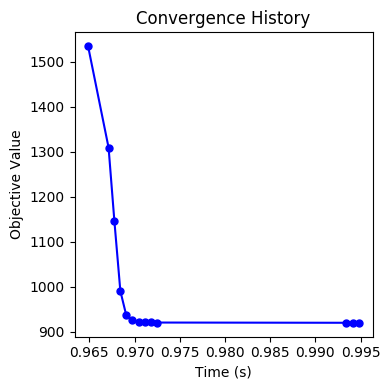

In [12]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(ch.times, ch.objective, color="b", marker="o", markersize=5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Objective Value")
ax.set_title("Convergence History")
plt.tight_layout()
plt.show()

### split the observations into `n_folds` folds.

TODO: ask Prof. Udell how this works when a MOF is missing from a row.

In [13]:
function k_fold_split(H::Array{Union{Missing, Float64}, 2}, k::Int; max_iter=1000, use_weighted_sampling::Bool=false)
    #@assert k > 1 "Choose a `k` greater than 1, otherwise this function is pointless"
    @printf("Splitting matrix into %d folds\n", k)
    if use_weighted_sampling
        @warn "Warning: You are using weighted sampling. Whether this is applicable in k-fold cross validation is unclear at the moment."
    end
    fold_matrix = fill(0, size(H))
    all_k_folds_not_represented_in_each_column = true
    n_iteration = 0

    while all_k_folds_not_represented_in_each_column
        n_iteration += 1
        all_k_folds_not_represented_in_each_column = false
        for j_col = 1:size(H)[2]
            # Grabs all available indices in row `i_row`
            i_indices = findall(.!ismissing.(H[:,j_col]))
            # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
            while length(i_indices) >= k
                for fold = 1:k
                    i = rand(1:length(i_indices))
                    fold_matrix[i_indices[i], j_col] = fold
                    deleteat!(i_indices, i)
                end
            end
            # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
            for i in i_indices
                if use_weighted_sampling
                    items = collect(1:k)
                    weights = [sum(fold_matrix[:, j_col] .!= _k .| fold_matrix[:, j_col] .!= 0) for _k = 1:k]
                    fold_matrix[i, j_col] = sample(items, Weights(weights))
                else
                    fold_matrix[i, j_col] = rand(1:k)
                end
            end
        end
        # We make sure we have enough data points in the columns as well
        for i_row = 1:size(H)[1]
            unique_folds = unique(fold_matrix[i_row, :])
            if length(unique_folds) <= k
                all_k_folds_not_represented_in_each_column = true
                break
            end
        end

        # If too many iteration are performed an Exception is raised.
        if n_iteration >= max_iter
            error("Maximum number of iterations reached. Try changing the `max_iter` argument.")
        end
    end
    
    for i = 1:size(H)[1]
        for j = 1:size(H)[2]
            if ismissing(H[i,j])
                continue
            else
                @assert fold_matrix[i,j] != -1 "A non-NaN value was not put in a fold"
            end
        end
    end
    
    @printf("Number of iterations required to split data into %d-folds: %d\n", k, n_iteration)
    for fold = 1:k
        @printf("Number of data points in fold %d: %d\n", fold, sum(fold_matrix .== fold))
    end
    @printf("Total number of data points: %d\n", sum(.!ismissing.(H)))
    @printf("-----------------------------------\n")
    return fold_matrix
end

fold_matrix = k_fold_split(H, 3, max_iter=100000, use_weighted_sampling=true)
temp_fold_matrix = replace(fold_matrix, 0 => missing)
kfolds = [(findall(collect(skipmissing(temp_fold_matrix))[:] .!= k), 
           findall(collect(skipmissing(temp_fold_matrix))[:] .== k)) 
                for k = 1:length(unique(fold_matrix))-1]
n_folds = length(kfolds)

Splitting matrix into 3 folds
Number of iterations required to split data into 3-folds: 42
Number of data points in fold 1: 135
Number of data points in fold 2: 136
Number of data points in fold 3: 142
Total number of data points: 413
-----------------------------------


┌ Warning: Warning: You are using weighted sampling. Whether this is applicable in k-fold cross validation is unclear at the moment.
└ @ Main In[13]:5


3

visualize the fold matrix

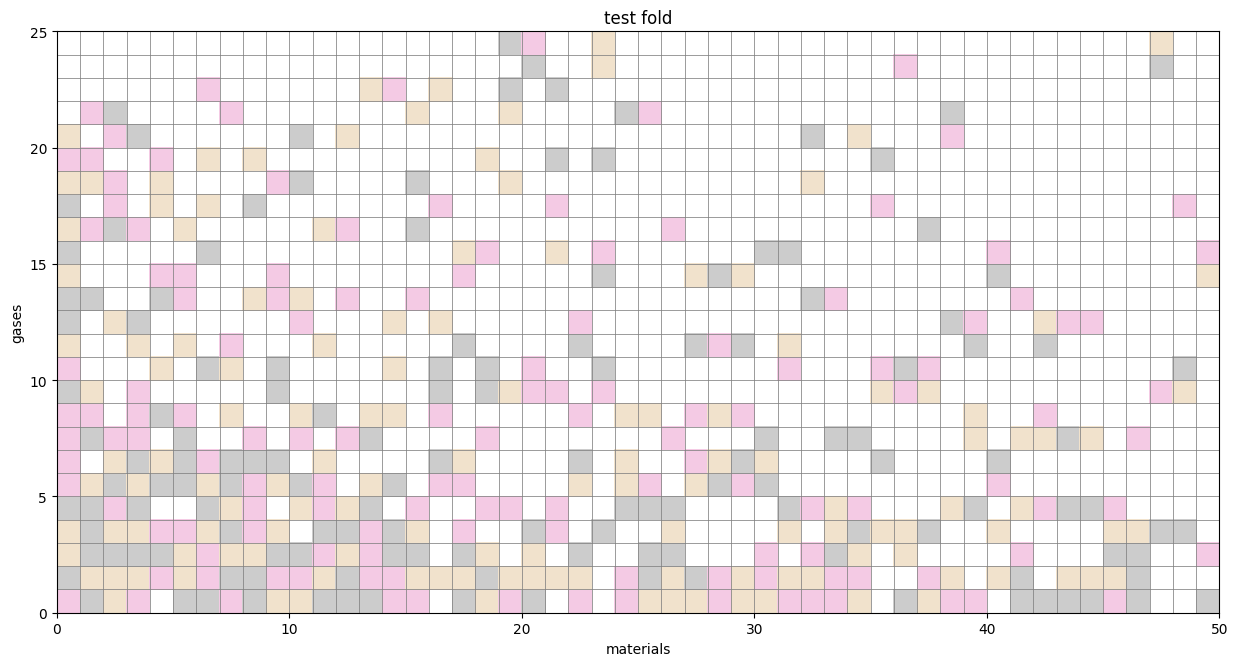

In [14]:
test_fold_matrix = Int.(zeros(size(H)))
for (i, fold) in enumerate(kfolds)
    for ix in fold[2]
        test_fold_matrix[ids_obs[ix][1], ids_obs[ix][2]] = i
    end
end

cmap = plt.get_cmap("Pastel2")
colors = cmap(collect(1:cmap.N))
#colors = Array{Float64, 2}(undef, 6, 4)
colors[1, :] .= [0.0, 0.0, 0.0, 0.0] ./ 255
# colors[2, :] .= [128., 0., 0., 255.] ./ 255
# colors[3, :] .= [170., 255., 195., 255.] ./ 255
# colors[4, :] .= [145., 30., 180., 255.] ./ 255
# colors[5, :] .= [255., 250., 200., 255.] ./ 255
# colors[6, :] .= [0., 130., 200., 255.] ./ 255
cmap = matplotlib.colors.ListedColormap(colors)



fig, ax = plt.subplots(figsize=(15, 15))
ax.pcolormesh(test_fold_matrix, cmap=cmap)

# grid lines
for x = 1:size(test_fold_matrix)[1]
    plot([0, size(test_fold_matrix)[2]], [x, x], linewidth=0.55, color="gray")
end
for y = 1:size(test_fold_matrix)[2]
    plot([y, y ], [0, size(test_fold_matrix)[1]], linewidth=0.55, color="gray")
end


ax.set_aspect("equal")
ax.set_xlabel("materials")
ax.set_ylabel("gases")
ax.set_title("test fold")
#ax.set_xlabel("Fold Frequency")
# TODO put legend in there for the fold
plt.savefig("prelim_fold_matrix.png", dpi=300, format="png")
plt.show()

## run cross-validation

specify the range of ranks and regularization params we aim to cover

In [15]:
ks = [1,2,3,4] # ranks
γs = 10.0 .^ range(-2.0, 2.0, length=25); # regularization params

map rank to color for data visualizations

In [16]:
cmap = PyPlot.matplotlib.cm.viridis
norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(ks), vmax=maximum(ks))
rank_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba

PyObject <bound method ScalarMappable.to_rgba of <matplotlib.cm.ScalarMappable object at 0x7f0ab28815c0>>

In [51]:
# get list of observations that belong to gas g
function ids_obs_gas(ids_obs::Array{Tuple{Int, Int}, 1}, g::Int)
    ids_obs_g = Tuple{Int64, Int64}[]
    for id_obs in ids_obs
        # if gas g is involved in this observation, push it
        if g == id_obs[1] # remember: H is transposed here.
            push!(ids_obs_g, id_obs)
        end
    end
    return ids_obs_g
end

# compute the spearmann rank correlation coeff between observations and predictions, 
#   under constraint that these observations correspond to gas g.
#   also return the number of observations with this gas.
function ρ_g(H::Array{Union{Float64, Missing}, 2}, Ĥ::Array{<:Number, 2}, 
        g::Int, ids_obs::Array{Tuple{Int, Int}, 1})
    # find all observations belonging to gas g
    ids_obs_g = ids_obs_gas(ids_obs, g)
    H_g = [H[i, j] for (i, j) in ids_obs_g]
    Ĥ_g = [Ĥ[i, j] for (i, j) in ids_obs_g]
    if length(ids_obs_g) in [0, 1]
        error("only zero or one obs, can't compute spearmann rank")
    end
    return length(ids_obs_g), corspearman(H_g, Ĥ_g)
end

function ρ_avg(H::Array{Union{Float64, Missing}, 2}, Ĥ::Array{<:Number, 2}, ids_obs::Array{Tuple{Int, Int}, 1})
    ρ = 0.0
    for g = 1:ng
        nb_obs_gas_g, ρg = ρ_g(H, Ĥ, g, ids_obs)
        ρ += ρg * nb_obs_gas_g
    end
    return ρ / length(ids_obs)
end

ρ_avg (generic function with 1 method)

In [52]:
kfolds = KFold(length(ids_obs), n_folds=5) #length(ids_obs)) # LOO
n_folds = length(kfolds)

5

run `n_folds` cross validation, store test error for each $(k, \gamma)$ combo

In [53]:
# TODO ask Prof. Udell if it makes any sense to regularize X, Y separately

# progress meter
p = Progress(n_folds * length(ks) * length(γs))

mse = Dict(k => zeros(length(γs)) for k in ks) # store MSE for each regularization param and k
ρ_g_wt_avg = Dict(k => zeros(length(γs)) for k in ks) # spearmann-rank
# loop over ranks
for (i_k, k) in enumerate(ks)
    # loop over regularization params
    for (i_γ, γ) in enumerate(γs)
        H_pred = [NaN for i = 1:ng, j = 1:nm]
        # loop over folds
        for (train_ids, test_ids) in kfolds
            # train model on training data
            G, M, glrm, ch = fit_glrm(k, γ, ids_obs[train_ids], verbose=false)
            # assess error on test data
            Ĥ = impute(glrm)
            for (g, m) in ids_obs[test_ids]
                @assert isnan(H_pred[g, m])
                H_pred[g, m] = Ĥ[g, m]
            end
            ProgressMeter.next!(p)
        end
        H_actual = [H[i, j] for (i, j) in ids_obs]
        mse[k][i_γ] = sum(([H_pred[i, j] for (i, j) in ids_obs] .- H_actual) .^ 2) / length(ids_obs)
        ρ_g_wt_avg[k][i_γ] = ρ_avg(H, H_pred, ids_obs)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


visualize average `n_fold` test set error against regularization param $\gamma$ for different ranks

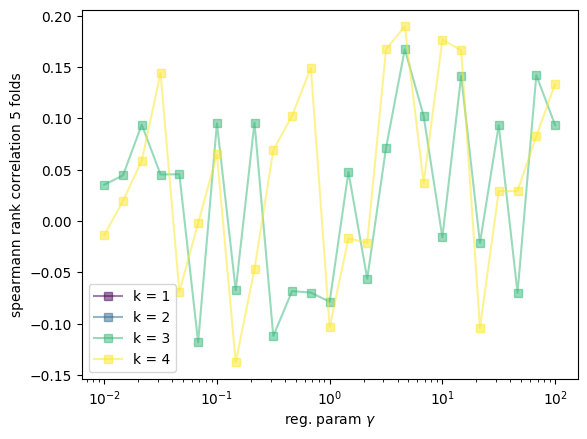

PyObject <matplotlib.legend.Legend object at 0x7f0aa78b1518>

In [54]:
figure()
xlabel(L"reg. param $\gamma$")
ylabel("spearmann rank correlation $n_folds folds")
for k in ks
    plot(γs, ρ_g_wt_avg[k], label=@sprintf("k = %d", k), marker="s", color=rank_to_color(k), alpha=0.5)
end
xscale("log")
legend()
# Udell ?: should call when we only have MOF offsets, k = 0 or k = 1?
# Udell ?: if we are not regularizing the offsets, why is k=1 fixed? do we need to change max_iter or something?

In [55]:
ρ_g_wt_avg[1]

25-element Array{Float64,1}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

## work with optimal model

In [20]:
min_mse = [minimum(mse[k]) for k in ks]
opt_k = ks[argmin(min_mse)] # optimum rank
opt_γ = γs[argmin(mse[opt_k])]

@show(min_mse)
@printf("optimum γ = %.3f, optimum k = %d\n", opt_γ, opt_k)

min_mse = [0.0, 0.0, 0.0, 0.0]
optimum γ = 0.015, optimum k = 1


### parity plot over `n_folds`-cross validation

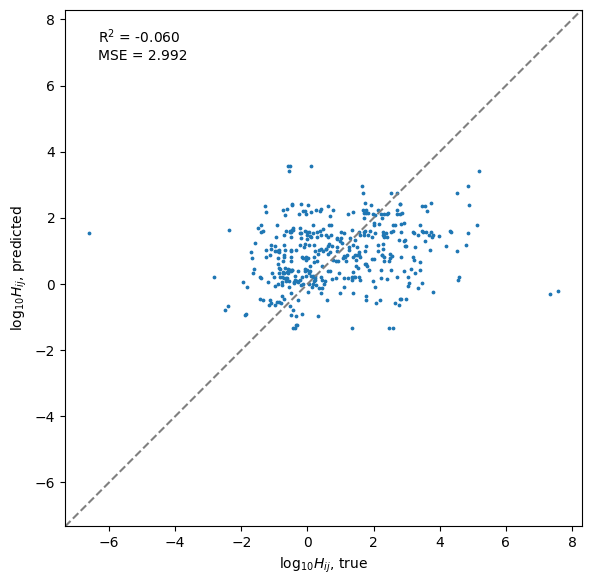

this_mse = 2.992289254368058
R² = -0.05977773298729194
Numerator: 1274.715
Denomirator: 1202.814


In [21]:
H_actual = Float64[]
H_pred = Float64[]
this_mse = 0.0
for (train_ids, test_ids) in kfolds
    # train model on training data
    G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs[train_ids], verbose=false)
    
    # test
    Ĥ = impute(glrm)
    @assert G' * M ≈ Ĥ
    H_pred = vcat(H_pred, [Ĥ[i, j] for (i, j) in ids_obs[test_ids]])
    H_actual = vcat(H_actual, [H[i, j] for (i, j) in ids_obs[test_ids]])
    this_mse = sum((H_pred .- H_actual) .^ 2) / length(test_ids)
end

this_mse /= n_folds
@show(this_mse)

R² = 1 - sum((H_pred .- H_actual) .^ 2) / sum((H_actual .- mean(H_actual)) .^ 2)
@show R²
@printf("Numerator: %.3f\n", sum((H_pred .- H_actual) .^ 2))
@printf("Denomirator: %.3f\n", sum((H_actual .- mean(H_actual)) .^ 2))


fig, ax = subplots(figsize=(6,6))
xlabel(L"$\log_{10} H_{ij}$, true")
ylabel(L"$\log_{10} H_{ij}$, predicted")
#hexbin(H_actual, H_pred, cmap="Greens", mincnt=1) #mincnt=1 makes bins white
scatter(H_actual, H_pred, s=3)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, linestyle="--", color="gray")
ax.text(xlim[1]+1, xlim[2]-1, @sprintf("R\$^2\$ = %.3f",R²))
ax.text(xlim[1]+1, xlim[2]-1.5, @sprintf("MSE = %.3f",this_mse))
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_aspect("equal")
plt.tight_layout()
plt.savefig("prelim_results.png", dpi=300, format="png")

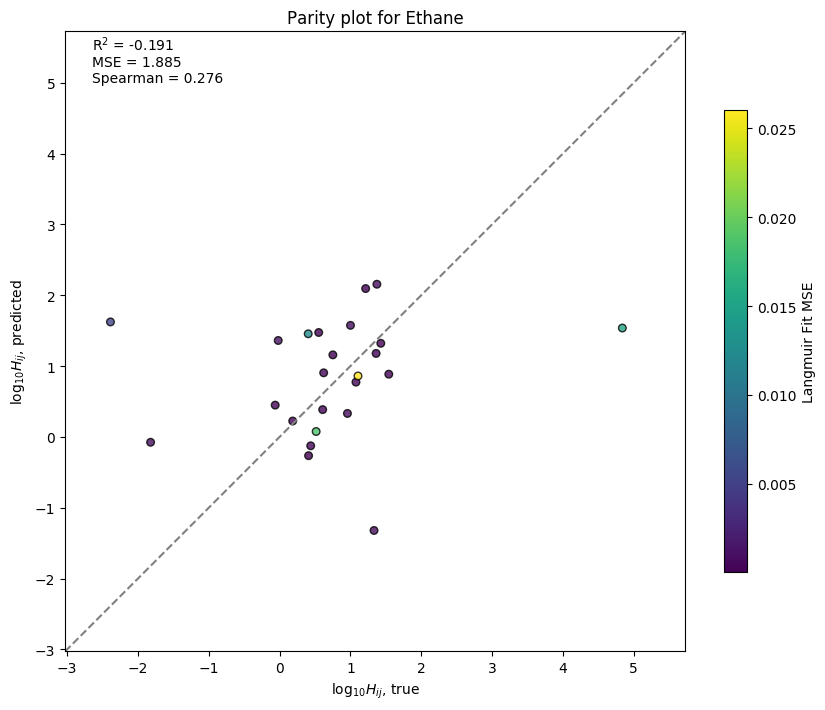

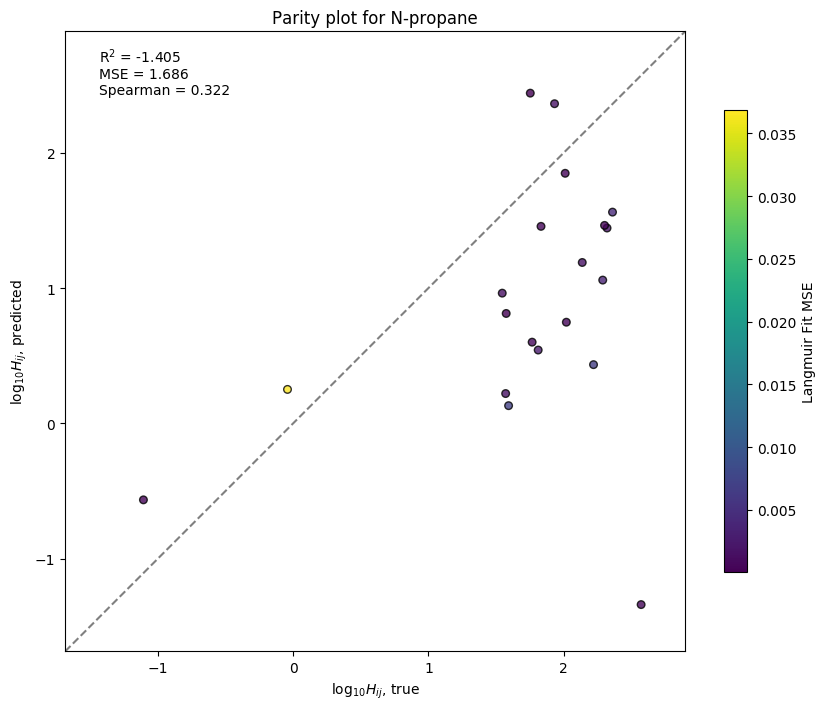

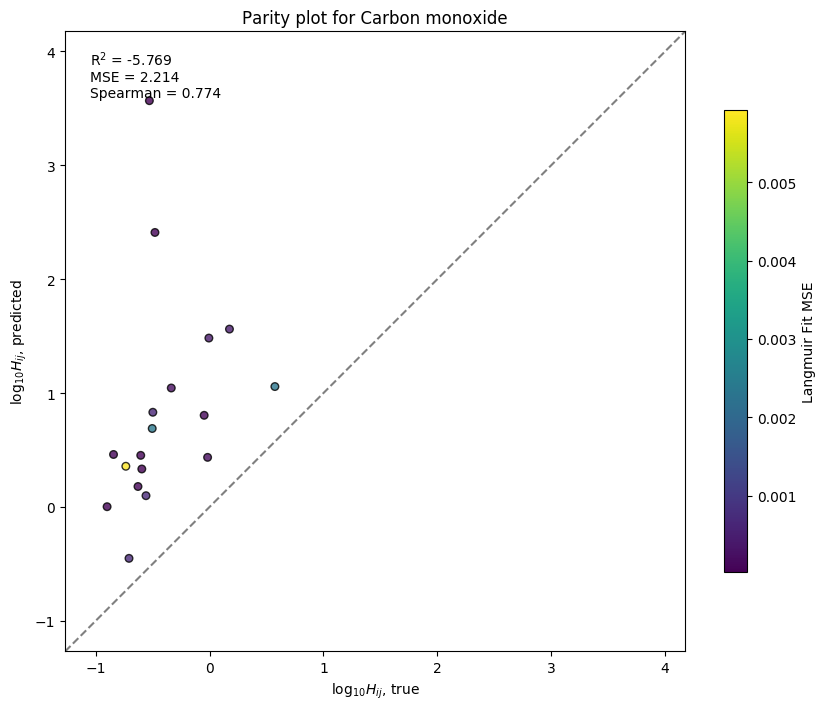

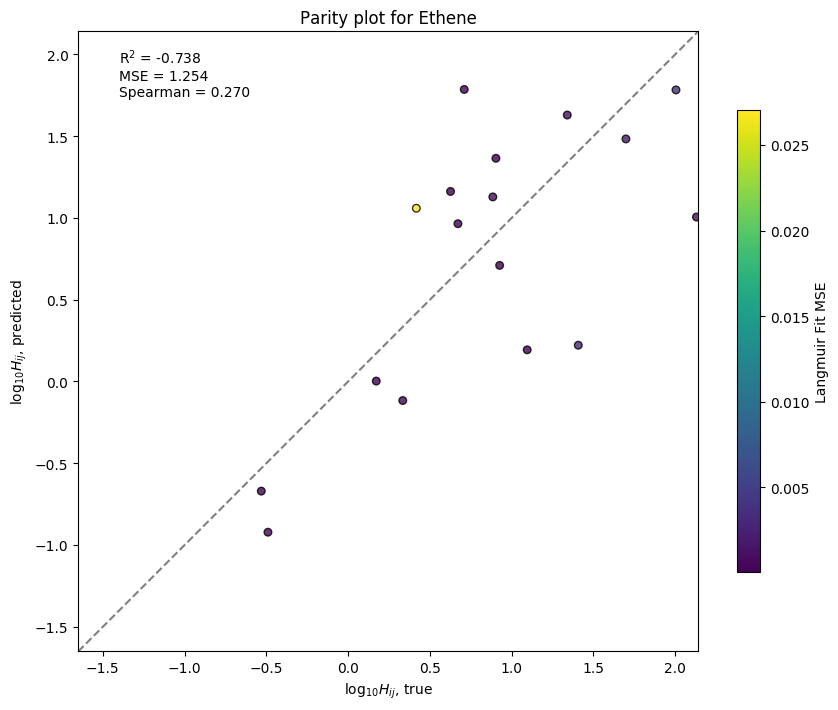

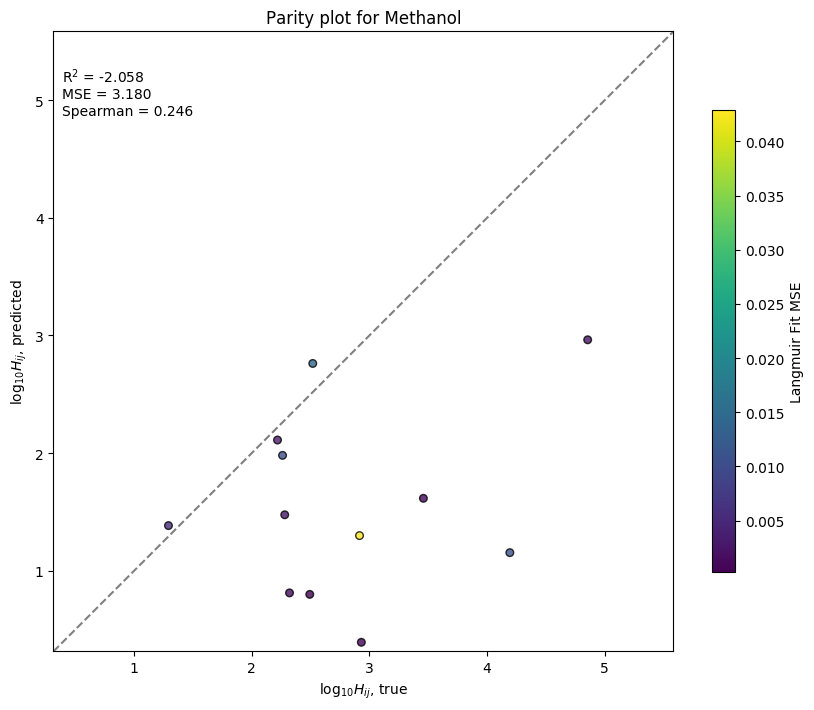

5-element Array{Nothing,1}:
 nothing
 nothing
 nothing
 nothing
 nothing

In [22]:
function gas_parity_plot(gas::Union{Int, AbstractString})
    if typeof(gas) <: AbstractString
        @assert gas in gases
        gas = findfirst(gas .== gases)
    end
    H_actual = Array{Float64, 1}()
    H_pred = Array{Float64, 1}()
    rmses = Array{Float64, 1}()
    langmuir_mse = Array{Float64, 1}()
    for (train_ids, test_ids) in kfolds
        # train model on training data
        G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs[train_ids], verbose=false)

        # test
        Ĥ = impute(glrm)
        H_pred = vcat(H_pred, [Ĥ[i, j] for (i, j) in ids_obs[test_ids] if i == gas])
        H_actual = vcat(H_actual, [H[i, j] for (i, j) in ids_obs[test_ids] if i == gas])
        langmuir_mse = vcat(langmuir_mse, [MSE[i, j] for (i, j) in ids_obs[test_ids] if i == gas])
    end
    mses = (H_pred .- H_actual) .^2 ./ length(H_pred)
    this_mse = sum(mses)
    R² = 1 - sum((H_pred .- H_actual) .^ 2) / sum((H_actual .- mean(H_actual)) .^ 2)
    #@show R²
    #@printf("Numerator: %.3f\n", sum((H_pred .- H_actual) .^ 2))
    #@printf("Denomirator: %.3f\n", sum((H_actual .- mean(H_actual)) .^ 2))
    spearman = corspearman(H_actual, H_pred)
    #@show spearman

    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=minimum(skipmissing(langmuir_mse)), vmax=maximum(skipmissing(langmuir_mse)))
    fig, ax = subplots(figsize=(10,10))
    ax.set_xlabel(L"$\log_{10} H_{ij}$, true")
    ax.set_ylabel(L"$\log_{10} H_{ij}$, predicted")
    if length(H_pred) > 800
        ax.hexbin(H_actual, H_pred, cmap="Greens", mincnt=1) #mincnt=1 makes bins white
    else
        #ax.scatter(H_actual, H_pred, s=30, fc="#469990", ec="k", alpha=0.8)
        sca = ax.scatter(H_actual, H_pred, c=cmap(norm(langmuir_mse)), s=30, ec="k", alpha=0.8)
    end
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.6)
    cbar.ax.set_ylabel("Langmuir Fit MSE")
    xlim = [ax.get_xlim()...]
    ylim = [ax.get_ylim()...]
    
    lim = diff(xlim)[1] > diff(ylim)[1] ? xlim : ylim
    ax.plot(lim.*1.1, lim.*1.1, linestyle="--", color="gray")
    ax.set_xlim(lim.*1.1)
    ax.set_ylim(lim.*1.1)
    ax.text(lim[1]+0.1, lim[2]-0.2, @sprintf("R\$^2\$ = %.3f\nMSE = %.3f\nSpearman = %.3f", R², sum((H_pred .- H_actual) .^ 2)/length(H_pred), spearman))

    ax.set_title("Parity plot for " * gases[gas])
    ax.set_aspect("equal")
    return nothing
end
gas_parity_plot.(6:10)

## viz offsets and latent space on fully trained model

In [23]:
G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs, verbose=false)

([1.0 1.0 … 1.0 1.0], [1.5514403307436908 0.5130111804413736 … 1.3705237577313956 1.2250178925772164], GLRM(Union{Missing, Float64}[0.7200604091332501 0.3624183242055701 … missing -0.21750255393260787; -0.07670314052307288 -0.2956537087926104 … missing missing; … ; missing missing … missing missing; missing missing … missing missing], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())  …  QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())], Regularizer[lastentry1(QuadReg(0.014677992676220698)), lastentry1(QuadReg(

### offsets $\mu_i$ representing material biases

In [24]:
these_means = [mean(skipmissing(H[:, i])) for i = 1:nm]

50-element Array{Float64,1}:
  1.5592618164643994  
  0.5160481344434895  
  0.16488930873475116 
 -0.025495589283184024
  0.9248859327423614  
  1.8209003527915455  
  2.1173214689555517  
  1.5151658102778598  
  0.3651696633595654  
 -0.10625409554018289 
  0.2630204679507983  
  1.5418293904097868  
  0.564073505573682   
  ⋮                   
  0.6323488072394546  
 -1.0156955156490424  
  2.0541544348142726  
 -0.6564389864887339  
 -0.9370337156998575  
  1.2183646156879935  
  1.3371663093721622  
  0.6257292272882797  
  0.19689891262580655 
  1.7083734532747474  
  1.364751044648396   
  1.223706410237387   

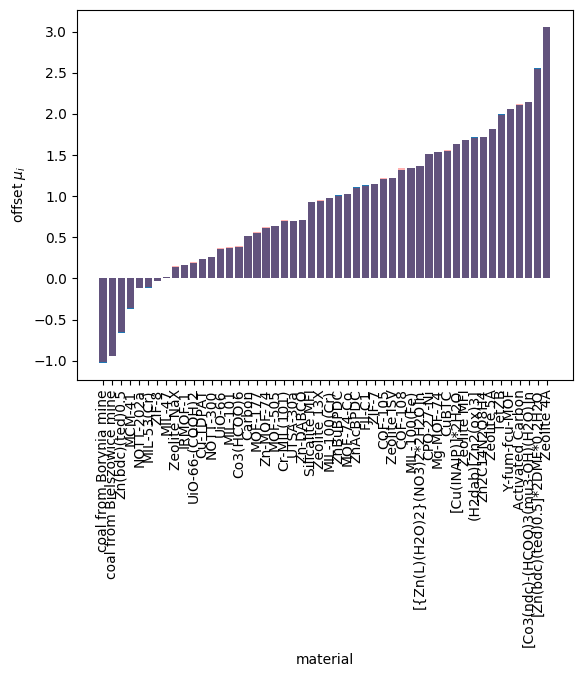

In [25]:
μ = M[end, :]

figure()
bar(1:nm, μ[sortperm(μ)])
bar(1:nm, these_means[sortperm(μ)], color="red", alpha=0.3)
xlabel("material")
ylabel(L"offset $\mu_i$")
xticks(1:nm, materials[sortperm(μ)], rotation=90);

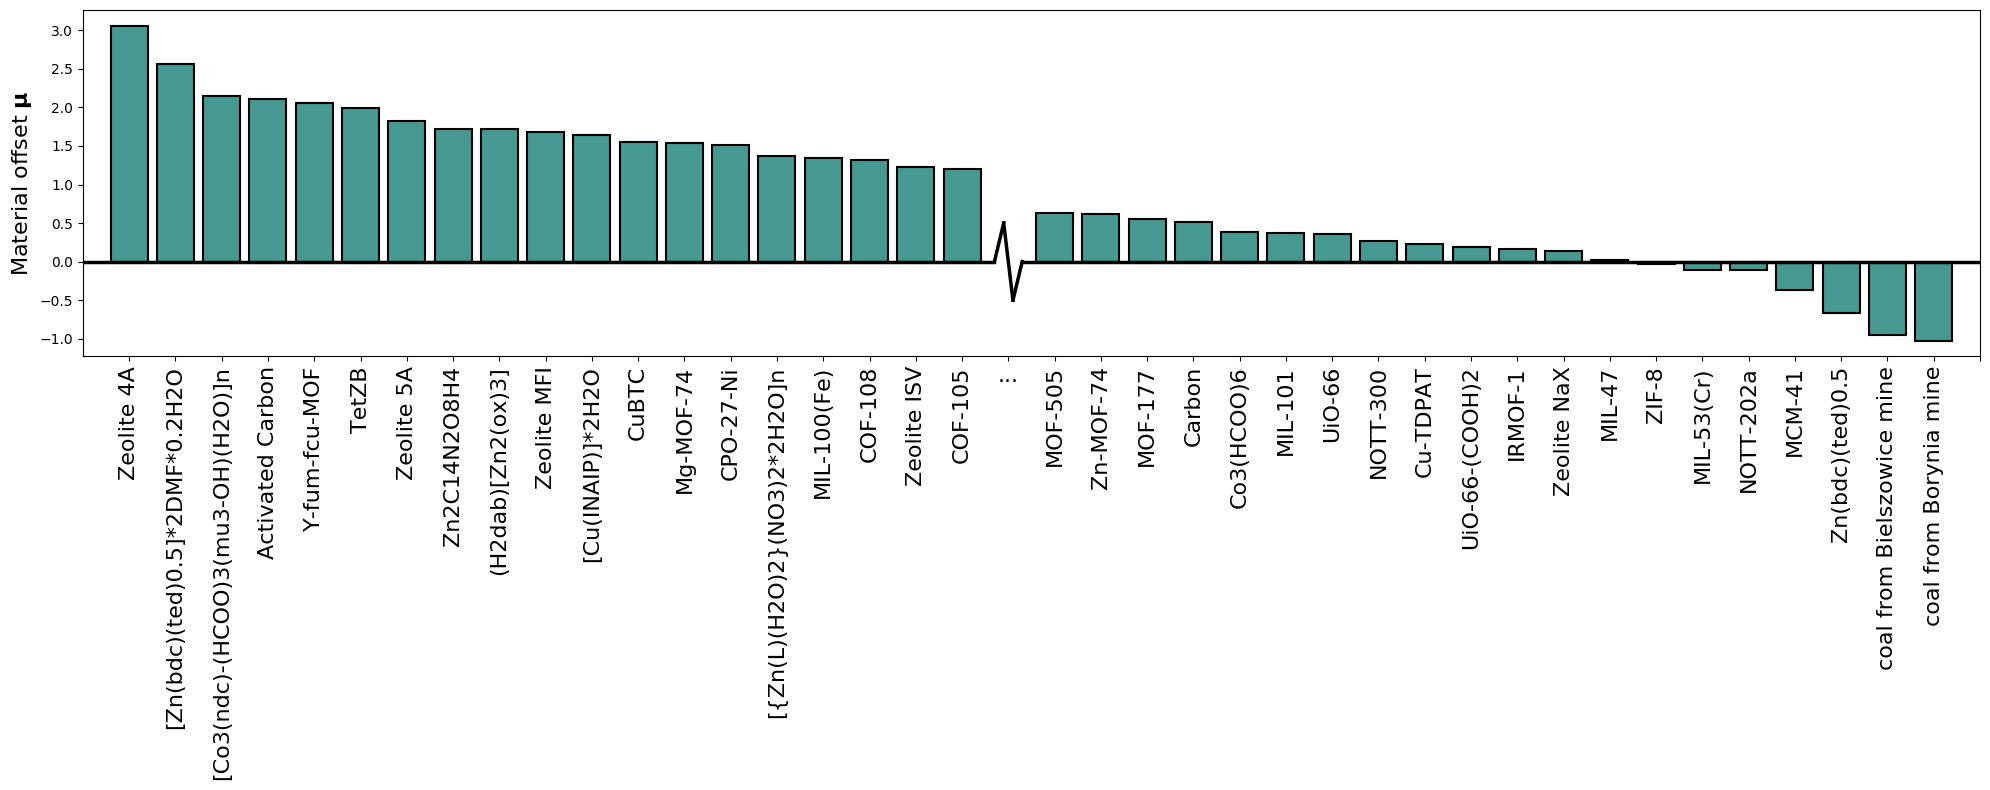

In [26]:
function plot_offset(μ::Array{Float64, 1}, show_all_materials=false)
    N = length(μ)
    sorted_idx = sortperm(μ)[end:-1:1]
    color = "#469990"
    edgecolor = "k"
    if N > 40 && !show_all_materials
        fig, ax = plt.subplots(figsize=(20,8))
        ax.bar(1:19, μ[sorted_idx][1:19], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        ax.bar(21:40, μ[sorted_idx][end-19:end], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        ax.plot([-1, 19.7], [0, 0], c=edgecolor, lw=2.5)
        ax.plot([20.3, 41], [0, 0], c=edgecolor, lw=2.5)
        ax.plot([19.7, 19.9], [0, 0.5], c=edgecolor, lw=2.5)
        ax.plot([19.9, 20.1], [0.5, -0.5], c=edgecolor, lw=2.5)
        ax.plot([20.1, 20.3], [-0.5, 0], c=edgecolor, lw=2.5)
        ax.set_xlim(0, 41)
    else
        fig, ax = plt.subplots(figsize=(20,8))
        ax.bar(1:N, μ[sorted_idx], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        xlim = ax.get_xlim()
        ax.plot(xlim, [0, 0], c=edgecolor, lw=3.5, alpha=0.5)
        ax.set_xlim(0, N)
    end
    
    
    ax.set_ylabel(L"Material offset $\mathbf{\mu}$", fontsize=16)
    xlabels = [material for material in materials[sorted_idx]]
    if N > 40 && !show_all_materials
        ax.set_xticks(1:41)
            ax.set_xticklabels(vcat(vcat(xlabels[1:19], ["..."]), xlabels[end-19:end]), rotation=90, fontsize=16)
        for tick in ax.get_xticklabels()
            if tick.get_text() == "..."
                tick.set_rotation(0)
            end
        end
    else
        ax.set_xticks(1:length(xlabels))
        ax.set_xticklabels(xlabels, rotation=90, fontsize=16)
    end
    #ax.set_title(mof_or_gas + ' biases from RecSys model', fontsize=16)
    plt.tight_layout()
    plt.savefig("prelim_offset.png", dpi=300, format="png")
    plt.show()
end
asdf = plot_offset(μ, false)

### latent space of materials